# Neural Network Learning

#### AI Saturday Lagos Begineers Class (Instructors: `Tejumade Afonja`, `Kenechi Dukor`, `Ifeanyi Igwegbe`)
This exercise is adopted from [Andrew Ng Machine Learning Course](https://www.coursera.org/learn/machine-learning)
and [voletiv's Notebook](https://github.com/voletiv/myPythonNeuralNetwork/blob/master/MNIST%20experiments.ipynb)

In [62]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat # Used to load the MATLAB *.mat files
import random # To pick random images to display
# To clear print buffer
from IPython.display import clear_output
import time

### Loading Data

The dataset ex4data1.mat, contains 5000 training examples of handwritten digits.
The .mat format means that that the data has been saved in a native MATLAB matrix format, instead of a text (ASCII) format like a csv-ﬁle. 

These matrices can be read directly into your program by using the load command. 

In [63]:
# Load MNIST DATA
# Use numpy.load() to load the .npz file
f = np.load('data/mnist_2.npz')
x_train, y_train = f['x_train'], f['y_train']
x_test, y_test = f['x_test'], f['y_test']
f.close()

We notice that the `X` and `y` values are saved in a dictionary. We can therefore access the keys

In [64]:
print("Shape of train features: ", x_train.shape, "\nShape of train labels: ", y_train.shape)
print("Shape of test features: ", x_test.shape, "\nShape of test labels: ", y_test.shape)

Shape of train features:  (60000, 28, 28) 
Shape of train labels:  (60000,)
Shape of test features:  (10000, 28, 28) 
Shape of test labels:  (10000,)


Notice that these images are of 28 x 28 pixel. Unlike in our previous class where the images are 20 x 20 pixel

In [65]:
# Reshaping x_train and x_test for our network with 784 inputs neurons
x_train = np.reshape(x_train, (len(x_train), 28*28))
x_test = np.reshape(x_test, (len(x_test), 28*28))

In [66]:
print("Shape of train features: ", x_train.shape, "\nShape of train labels: ", y_train.shape)
print("Shape of test features: ", x_test.shape, "\nShape of test labels: ", y_test.shape)

Shape of train features:  (60000, 784) 
Shape of train labels:  (60000,)
Shape of test features:  (10000, 784) 
Shape of test labels:  (10000,)


### Visualize Data

Lets visualize the data using the same codes we used in the previous class

In [67]:
import matplotlib.gridspec as gridspec

In [68]:
M = x_train.shape[0] # = 60000 pixels per sample
N = x_train.shape[1] # = 784 samples
dim = len(np.unique(y_train)) # = 10 distinct classes for this example.

examples = x_train[np.random.randint(M, size = dim * dim)] # pick random row, which is an unrolled image.
examples.shape

(100, 784)

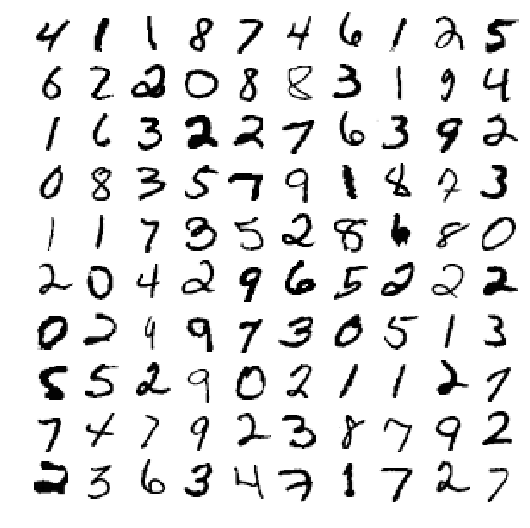

In [69]:
fig = plt.figure(figsize=(7, 7))

gs = gridspec.GridSpec(dim, dim)
gs.update(bottom=0.01, top=0.99, left=0.01, right=0.99, 
          hspace=0.05, wspace=0.05)

k = 0
for i in range(dim):
    for j in range(dim):
        ax = plt.subplot(gs[i, j])
        ax.axis('off')
        ax.imshow(examples[k].reshape(int(np.sqrt(N)), int(np.sqrt(N))), # no transpose here, unlike the other exercise
            cmap=plt.get_cmap('Greys'), interpolation='nearest')
        k += 1

### Preprocess Data

We want to do the following to the data:
- we want to normalize our input data.
- we want to make sure that the y_train and y_train data is an n x 10 matrix.

In [70]:
# Normalize x_train
x_train = x_train / 255.0
x_test = x_test / 255.0

# Make new y_train of nx10 elements since we have 10 digit labels
new_y_train = np.zeros((len(y_train), 10))
for i in range(len(y_train)):
    new_y_train[i, y_train[i]] = 1

del y_train
y_train = new_y_train
print(y_train.shape)

# Make new y_test of nx10 elements
new_y_test = np.zeros((len(y_test), 10))
for i in range(len(y_test)):
    new_y_test[i, y_test[i]] = 1

del y_test
y_test = new_y_test
print(y_test.shape)

(60000, 10)
(10000, 10)


### Weight Initialization

The function below will initialize random weight for any layers size and network depth. The weights will be saved in an array

In [71]:
# Initializing weight matrices from any layer sizes
def initializeWeights(layers):
#     weights = [np.random.randn(j, i+1) for i, j in zip(layers[:-1], layers[1:])]
    weights = []
    for i, j in zip(layers[:-1], layers[1:]):
        weights.append(np.random.randn(j, i+1))
    return weights

In [72]:
# layers = [3, 4, 4, 2]

In [73]:
# for i, j in zip(layers[:-1], layers[1:]):
#     print(i,j)

### Bias Term
Here, we will be using a function to add our bias term (one's) into the input features.
We want it this way because we need to add the bias term to every input intpo any layer for the total number of layer we will be creating.

In [74]:
# Add a bias term to every data point in the input
def addBiasTerms(X):
        # Make the input an np.array()
        X = np.array(X)
        
        # Forcing 1D vectors to be 2D matrices of 1xlength dimensions
        if X.ndim == 1:
            X = np.reshape(X, (1, len(X)))
        
        # Inserting bias terms; Insert a column of 1's to X
        X = np.c_[np.ones(X.shape[0]), X]
        # X = np.insert(X, 0, 1, axis=1)
        
        return X

### Sigmoid function

Now, lets implement the sigmoid function that we discussed in class. 
Remember that we modified the hypothesis for logistic regression as follows:

$$h_\theta(x) = g(\theta^Tx)$$

where $g$ is the sigmoid function defined as:
$$g(z) = \frac{1}{1+e^{-z}}$$

In [75]:
# Sigmoid function
def sigmoid(z):
    return 1/(1 + np.exp(-z))

### Forward Propagation

In [76]:
# Forward Propagation of outputs
def forwardProp(X, weights):
    # Initializing an empty list of outputs
    outputs = []
    
    # Assigning a name to reuse as inputs
    inputs = X
    
    # For each layer
    for w in weights:
        # Add bias term to input
        inputs = addBiasTerms(inputs)
        
        # Y = Sigmoid ( X .* W^T )
        outputs.append(sigmoid(inputs @ w.T))
        
        # Input of next layer is output of this layer
        inputs = outputs[-1]
        
    return outputs

### Cost Function

Now lets implement the cost function that we also discussed in class.

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$

where the cost 
- `J = -log(h) when y = 1`
- `J = -log(1 - h) when y = 0`

In [77]:
# Compute COST (J) of Neural Network
def nnCost(weights, X, y):
    # Calculate yPred
    h = forwardProp(X, weights)[-1]
    m = len(y)
    
    # Compute J
    J = 0.5*np.sum(np.square(h - y))/m
    
    return J

### Training Evaluation Function

In [78]:
# Evaluate the accuracy of weights for input X and desired outptut Y
def evaluate(weights, X, y):
    h = forwardProp(X, weights)[-1]
    # Check if maximum probability is from that neuron corresponding to desired class,
    # AND check if that maximum probability is greater than 0.5
    evaluated = sum( int( ( np.argmax(h[i]) == np.argmax(y[i]) ) and 
                    ( (h[i][np.argmax(h[i])]>0.5) == (y[i][np.argmax(y[i])]>0.5) ) )
              for i in range(len(y)) )
    return evaluated

### Back Propagation

In [79]:
# IMPLEMENTING BACK-PROPAGATION WITH LEARNING RATE, MOMENTUM, NAG, ADAGRAD
def backProp(weights, X, Y, learningRate, optimizer=None, mu=0.9):
    # Forward propagate to find outputs
    outputs = forwardProp(X, weights)
    
    # For the last layer, bpError = error = yPred - Y
    bpError = outputs[-1] - Y
    
    # Initialize velocity in the shape of weights for use with momentum and NAG
    v = [np.zeros(w.shape) for w in weights] # Create an array of zeros like the "weight" array
    prevV = [np.zeros(w.shape) for w in weights]
    
    # Initialize cache for use with Adagrad
    cache = [np.zeros(w.shape) for w in weights]
    
    # Back-propagating from the last layer to the first
    for l, w in enumerate(reversed(weights)):
        
        # Find yPred for this layer
        yPred = outputs[-l-1]
        
        # Calculate delta for this layer using bpError from next layer
        delta = np.multiply(np.multiply(bpError, yPred), 1-yPred)
        
        # Find input to the layer, by adding bias to the output of the previous layer
        # Take care, l goes from 0 to 1, while the weights are in reverse order
        if l==len(weights)-1: # If 1st layer has been reached
            xL = addBiasTerms(X)
        else:
            xL = addBiasTerms(outputs[-l-2])
        
        # Calculate the gradient for this layer
        grad = np.dot(delta.T, xL)/len(Y)
        
        # Calculate bpError for previous layer to be back-propagated
        bpError = np.dot(delta, w)
        
        # Ignore bias term in bpError
        bpError = bpError[:,1:]
        
        # CHANGE WEIGHTS of the current layer (W <- W + eta*deltaW)
        if optimizer is None:
            w += -learningRate * grad
        
        # Momentum
        if optimizer is 'momentum':
            v[-l-1] = mu * v[-l-1] - learningRate * grad
            w += v[-l-1]
        
        # Nesterov Momentum
        if optimizer is 'nag':
            prevV[-l-1] = np.array(v[-l-1]) # back this up
            v[-l-1] = mu * v[-l-1] - learningRate * grad # velocity update stays the same
            w += -mu * prevV[-l-1] + (1 + mu) * v[-l-1] # position update changes form
        
        # Adagrad
        if optimizer is 'adagrad':
            cache[-l-1] += grad**2
            w += - learningRate * grad / (np.sqrt(cache[-l-1]) + np.finfo(float).eps)

### Training Function Using Mini-Batch Gradient Descent

In [80]:
# TRAINING USING MINI-BATCH GRADIENT DESCENT
def trainUsingMinibatchGD(weights, X, Y, minibatchSize, nEpochs, learningRate=1.0, 
                          decay=None, decayRate=0.1, optimizer=None, mu=0.9, testX=None, testY=None):
    # If testing data is not provided, check accuracy on training data
    if testX is None:
        testX = X
        testY = Y
    
    # Check cost and accuracy
    # Initialize cost
    prevCost = nnCost(weights, testX, testY)
    yes = evaluate(weights, testX, testY)
    print("Before training: "+str(yes)+" of "+str(len(testY))+" = "+str(round(float(yes/len(testY)),4))+
          "; cost="+str(prevCost))
    
    # Backup weights to revert back in case cost increases
    oldWeights = [np.array(w) for w in weights]
    
    # To count the number of times learning rate had to be halved contiguously
    countLRHalf = 0
    
    # Initialize index for iteration through epochs
    epoch = 0
    
    # For nEpochs number of epochs:
    while epoch < nEpochs:
        # clear output
        #clear_output()
        
        # Make a list of all the indices
        fullIdx = list(range(len(Y)))
        
        # Shuffle the full index
        np.random.shuffle(fullIdx)
        
        # Count number of mini-batches
        nOfMinibatches = int(len(X)/minibatchSize)
        
        # For each mini-batch
        for m in range(nOfMinibatches):
            
            # Compute the starting index of this mini-batch
            startIdx = m*minibatchSize
            
            # Declare sampled inputs and outputs
            xSample = X[fullIdx[startIdx:startIdx+minibatchSize]]
            ySample = Y[fullIdx[startIdx:startIdx+minibatchSize]]

            # Run backprop, with an optimizer
            backProp(weights, xSample, ySample, learningRate, optimizer, mu)
         
        # Check cost and accuracy
        cost = nnCost(weights, testX, testY)
        yes = evaluate(weights, testX, testY)
        print("Epoch "+str(epoch+1)+" of "+str(nEpochs)+" : "+
              str(yes)+" of "+str(len(testY))+" = "+str(round(float(yes/len(testY)),4))+
              "; cost="+str(cost))
        
        # If decay type is 'step', when cost increases, revert back weights and halve learning rate 
        if decay is 'step':
            # If cost does not decrease
            if cost >= prevCost:
                # Revert weights back to those at the start of this epoch
                weights = [np.array(w) for w in oldWeights]
                
                # Recalculate prevCost
                cost = nnCost(weights, testX, testY)
                
                # Halve the learning rate
                learningRate = learningRate/2.0
                
                # Revert iteration number
                epoch -= 1
                
                # Increment the count of halving learning rate by 1
                countLRHalf += 1
                
                print("Halving learning rate to: "+str(learningRate)+", count="+str(countLRHalf))
            # If cost decreases, reset the count to 0
            else:
                countLRHalf = 0
        
        # If decay is 'time'
        if decay is 'time':
            learningRate *= np.exp(-decayRate)
        
        # If learningRate has been halved contiguously for too long, break
        if countLRHalf is 10:
            break
        
        # Set prevCost for next epoch
        prevCost = cost
        
        # Set oldWeights for next epoch
        oldWeights = [np.array(w) for w in weights]
        
        # Increase iteration number for epochs
        epoch += 1
    
    # If training was stopped because accuracy was not increasing
    if epoch < nEpochs:
        print("Training ended prematurely...")
    # If training ended in correct number of epochs
    else:
        print("Training complete.")
    
    # Printing training accuracy
    yes = evaluate(weights, X, Y)
    print("TRAINING ACCURACY, COST : "+str(yes)+" of "+str(len(Y))+
          " = "+str(round(float(yes/len(Y)),4)))
    
    # Printing test accuracy
    if testY is not Y:
        yes = evaluate(weights, testX, testY)
        print("TEST ACCURACY, COST : "+str(yes)+" of "+str(len(testY))+
              " = "+str(round(float(yes/len(testY)),4)))

### Function Checker
Lets use the `AND` operation we learnt in the previous class to check our functions

In [81]:
# Initialize network
layers = [2, 2, 1]
weights = initializeWeights(layers)

print("weights:")
for i in range(len(weights)):
    print(i+1); print(weights[i].shape); print(weights[i])

# Declare input and desired output for AND gate
X = np.array([[0,0], [0,1], [1,0], [1,1]])
Y = np.array([[0], [0], [0], [1]])

# Check current accuracy and cost
print("Cost: "+str(nnCost(weights, X, Y)))
yes = evaluate(weights, X, Y)
print("Accuracy: "+str(yes)+" of "+str(len(Y))+" = "+str(round(float(yes/len(Y)), 4)))
print(forwardProp(X, weights)[-1])

weights:
1
(2, 3)
[[-0.07127424  0.6522512   1.37436371]
 [ 0.04823283  1.7063859   0.33080934]]
2
(1, 3)
[[ 0.93254655  1.10285979 -0.84732371]]
Cost: 0.21608381252073205
Accuracy: 1 of 4 = 0.25
[[0.73700435]
 [0.78529227]
 [0.71451801]
 [0.75859755]]


### Training

This will achieve the minimum accuracy that can be obtained

In [82]:
# TRAIN using Mini-batch Gradient Descent

# Initialize network
layers = [784, 30, 10]
weights = initializeWeights(layers)

# Take backup of weights to be used later for comparison
#initialWeights = [np.array(w) for w in weights]

# Set options of mini-batch gradient descent
minibatchSize = 10
nEpochs = 30
learningRate = 3.0
mu = 0.9

# Train
trainUsingMinibatchGD(weights, x_train, y_train, minibatchSize, nEpochs, learningRate,
                      decay='step', optimizer='nag', mu=mu, testX=x_test, testY=y_test)

Before training: 1027 of 10000 = 0.1027; cost=2.865150102229949
Epoch 1 of 30 : 8641 of 10000 = 0.8641; cost=0.07589750794366182
Epoch 2 of 30 : 9125 of 10000 = 0.9125; cost=0.054541365527505443
Epoch 3 of 30 : 9183 of 10000 = 0.9183; cost=0.050169032020411786
Epoch 4 of 30 : 9124 of 10000 = 0.9124; cost=0.05291750478811133
Halving learning rate to: 1.5, count=1
Epoch 4 of 30 : 9248 of 10000 = 0.9248; cost=0.04490844414384316
Epoch 5 of 30 : 9289 of 10000 = 0.9289; cost=0.04250530787666245
Epoch 6 of 30 : 9321 of 10000 = 0.9321; cost=0.04227155234952174
Epoch 7 of 30 : 9299 of 10000 = 0.9299; cost=0.04227323051761753
Halving learning rate to: 0.75, count=1
Epoch 7 of 30 : 9342 of 10000 = 0.9342; cost=0.041224573976586694
Epoch 8 of 30 : 9340 of 10000 = 0.934; cost=0.040529055482684644
Epoch 9 of 30 : 9355 of 10000 = 0.9355; cost=0.040736706688673505
Halving learning rate to: 0.375, count=1
Epoch 9 of 30 : 9350 of 10000 = 0.935; cost=0.0401332833760259
Epoch 10 of 30 : 9371 of 10000 = 0

### Save the Weights

In [83]:
np.save("nagWeights_mini10_epochs30_lr3.0_mu0.9", weights)

Train with two hidden layers

In [ ]:
# TRAIN using Mini-batch Gradient Descent

# Initialize network
layers = [784, 30, 30, 10]
weights = initializeWeights(layers)

# Set options of mini-batch gradient descent
minibatchSize = 10
nEpochs = 60
learningRate = 3.0
mu = 0.9

# Train
trainUsingMinibatchGD(weights, x_train, y_train, minibatchSize, nEpochs, learningRate,
                      decay=None, optimizer='nag', mu=mu, testX=x_test, testY=y_test)